# "В один клик"

# Проблема:

Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

# Цель:
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

# Решение:

Нужно промаркировать уровень финансовой активности постоянных покупателей.

В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

# План работы:

- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Объединение таблиц
- Шаг 5. Корреляционный анализ
- Шаг 6. Использование пайплайнов
- Шаг 7. Анализ важности признаков
- Шаг 8. Сегментация покупателей
- Шаг 9. Общий вывод

# Описание данных:

market_file.csv - 
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.


market_time.csv -
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.


- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.
- money.csv
- Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Загрузка данных

### Импорты

In [1]:
!pip install phik -q
!pip install matplotlib==3.3.4 -q
!pip install shap==0.41.0 -q
!pip install scikit-learn==1.1.0 -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка

In [4]:
market_file_path = "/datasets/market_file.csv"
market_money_path = "/datasets/market_money.csv"
market_time_path = "/datasets/market_time.csv"
money_path = "/datasets/money.csv"

# Загрузка данных из файлов с учетом различных разделителей
market_file = pd.read_csv(market_file_path, delimiter=',')
market_money = pd.read_csv(market_money_path, delimiter=',')
market_time = pd.read_csv(market_time_path, delimiter=',')
money = pd.read_csv(money_path, delimiter=';')

### Вывод первых нескольких строк каждой таблицы для проверки

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Каждая таблица содержит столбец "id", который, вероятно, является ключевым для объединения таблиц. Каждая таблица также содержит другие характеристики, описывающие данные о покупателях, выручке, времени и т.д. Кроме того, можно заметить, что в таблице "money" десятичные значения записаны с запятой вместо точки, что соответствует указанию в описании данных.

### Посмотрим размерности каждой таблицы

In [9]:
market_file.shape

(1300, 13)

In [10]:
market_money.shape

(3900, 3)

In [11]:
market_time.shape

(2600, 3)

In [12]:
money.shape

(1300, 2)

### Вывод:
Загрузили данные и настроили разграничители

## Предобработка данных
Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

### Приведение к единому виду

In [13]:
# Приведение всех названий столбцов к snake_case и нижнему регистру
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_')
market_money.columns = market_money.columns.str.lower().str.replace(' ', '_')
market_time.columns = market_time.columns.str.lower().str.replace(' ', '_')
money.columns = money.columns.str.lower().str.replace(' ', '_')

# Преобразование десятичных значений из строки в число с плавающей точкой (если необходимо)
money['прибыль'] = money['прибыль'].str.replace(',', '.').astype(float)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Названия столбцов приведены к стандарту PEP8 — к «змеиному» регистру. Прибыль переведена в численный тип шкалы 👍
</div>

In [14]:
print(market_file.head())

       id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей             

### Информация о типах данных

In [15]:
# Вывод типов данных для каждого столбца таблицы market_file
print("Типы данных для каждого столбца в таблице market_file:")
print(market_file.dtypes)

# Вывод типов данных для каждого столбца таблицы market_money
print("\nТипы данных для каждого столбца в таблице market_money:")
print(market_money.dtypes)

# Вывод типов данных для каждого столбца таблицы market_time
print("\nТипы данных для каждого столбца в таблице market_time:")
print(market_time.dtypes)

# Вывод типов данных для каждого столбца таблицы money
print("\nТипы данных для каждого столбца в таблице money:")
print(money.dtypes)

Типы данных для каждого столбца в таблице market_file:
id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

Типы данных для каждого столбца в таблице market_money:
id           int64
период      object
выручка    float64
dtype: object

Типы данных для каждого столбца в таблице market_time:
id         int64
период    object
минут      int64
dtype: object

Типы данных для каждого столбца в таблице money:
id           int64
пр

Вроде всё так, как должно быть...

### Просмотр уникальных значений:

In [16]:
# Вывод уникальных значений для таблицы market_file
print("Уникальные значения в таблице market_file:")
for column in market_file.columns:
    unique_values = market_file[column].unique()
    print(f"{column}: {unique_values}")

# Вывод уникальных значений для таблицы market_money
print("\nУникальные значения в таблице market_money:")
for column in market_money.columns:
    unique_values = market_money[column].unique()
    print(f"{column}: {unique_values}")

# Вывод уникальных значений для таблицы market_time
print("\nУникальные значения в таблице market_time:")
for column in market_time.columns:
    unique_values = market_time[column].unique()
    print(f"{column}: {unique_values}")

# Вывод уникальных значений для таблицы money
print("\nУникальные значения в таблице money:")
for column in money.columns:
    unique_values = money[column].unique()
    print(f"{column}: {unique_values}")

Уникальные значения в таблице market_file:
id: [215348 215349 215350 ... 216645 216646 216647]
покупательская_активность: ['Снизилась' 'Прежний уровень']
тип_сервиса: ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать: ['да' 'нет']
маркет_актив_6_мес: [3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]
маркет_актив_тек_мес: [5 4 3]
длительность: [ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  219  377
  472  806  449  523  503  515  813  249  186  336  690  824  753  674
  875  844  602  855  448  344  922  298  893  881  372  788  937  764
  851 1021  627  748  684  719  891 

Видим, что в таблицах есть опечатки в названиях категорий, которые нужно исправить:
- значение 'стандартт' в столбце 'тип_сервиса' в датафрейме market_file
- значение 'предыдцщий_месяц' в столбце 'период' в датафрейме market_time

### Исправим опечатки

In [17]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

In [18]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Названия категорий исправлены, всё хорошо.
</div>

### Проверка на пропуски и дубликаты

In [19]:
# Пропуски
print("Пропуски в market_file:")
print(market_file.isnull().sum())

print("\nПропуски в market_money:")
print(market_money.isnull().sum())

print("\nПропуски в market_time:")
print(market_time.isnull().sum())

print("\nПропуски в money:")
print(money.isnull().sum())

Пропуски в market_file:
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

Пропуски в market_money:
id         0
период     0
выручка    0
dtype: int64

Пропуски в market_time:
id        0
период    0
минут     0
dtype: int64

Пропуски в money:
id         0
прибыль    0
dtype: int64


In [20]:
# Дубликаты
print("\nКоличество дубликатов в таблице market_file:", market_file.duplicated().sum())
print("Количество дубликатов в таблице market_money:", market_money.duplicated().sum())
print("Количество дубликатов в таблице market_time:", market_time.duplicated().sum())
print("Количество дубликатов в таблице money:", money.duplicated().sum())


Количество дубликатов в таблице market_file: 0
Количество дубликатов в таблице market_money: 0
Количество дубликатов в таблице market_time: 0
Количество дубликатов в таблице money: 0


### Проверим итоговый результат предобработки

In [21]:
market_file.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
56,215404,Снизилась,стандарт,да,2.4,3,699,0.94,Домашний текстиль,4,1,2,3
581,215929,Снизилась,премиум,да,4.0,4,599,0.15,Товары для детей,2,8,4,7
91,215439,Снизилась,премиум,нет,3.4,5,448,0.28,Товары для детей,4,2,2,7
1286,216634,Прежний уровень,стандарт,да,4.1,4,335,0.40,Техника для красоты и здоровья,3,4,3,7
1288,216636,Прежний уровень,премиум,да,2.4,4,996,0.23,Кухонная посуда,3,4,5,6


In [22]:
market_money.sample(5)

,id,период,выручка
376,215473,предыдущий_месяц,4246.5
2027,216023,предыдущий_месяц,3722.0
1275,215773,предыдущий_месяц,4515.0
3218,216420,препредыдущий_месяц,4536.0
3542,216528,текущий_месяц,3891.0


In [23]:
market_time.sample(5)

,id,период,минут
2195,216445,текущий_месяц,9
1397,216046,текущий_месяц,20
2071,216383,текущий_месяц,7
610,215653,текущий_месяц,13
1107,215901,предыдущий_месяц,18


In [24]:
money.sample(5)

,id,прибыль
578,215926,4.47
649,215997,3.89
1239,216587,2.00
625,215973,3.54
799,216147,4.94


In [25]:
market_money.rename(columns={'период': 'период_доход'}, inplace=True)

In [26]:
market_time.rename(columns={'период': 'период_сайт'}, inplace=True)

### Вывод:

Выполнили предобработку данных:
- Привели к единому виду, проверили наличие пропусков и дубликатов, исправили ошибки


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Предобработка данных выполнена корректно.
</div>

## Исследовательский анализ данных
Проведите исследовательский анализ данных из каждой таблицы.

Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период
Оформите выводы по результатам шага.

### Проведём исследовательский анализ данных каждой таблицы

#### market_file

In [27]:
print(market_file.describe())

                  id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.0

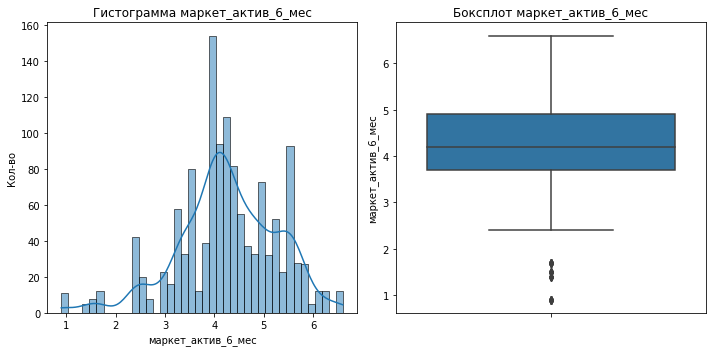

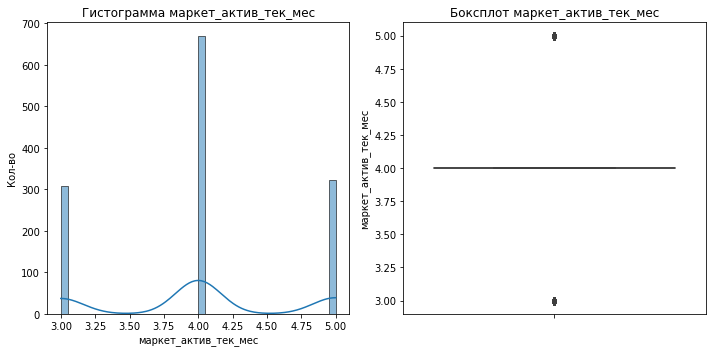

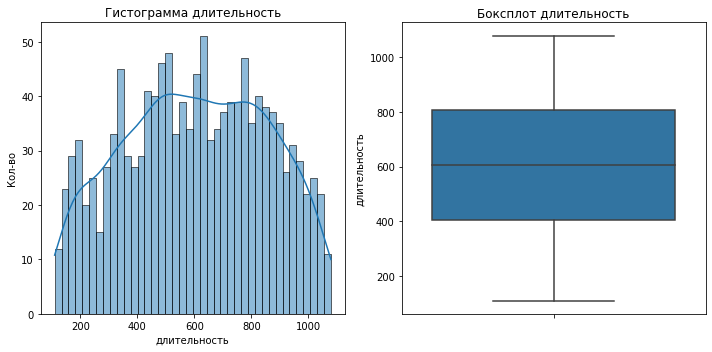

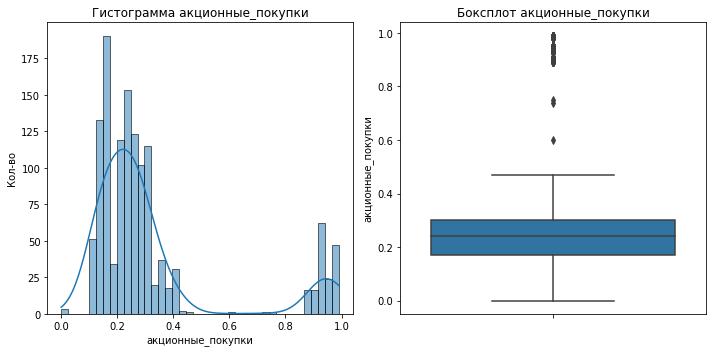

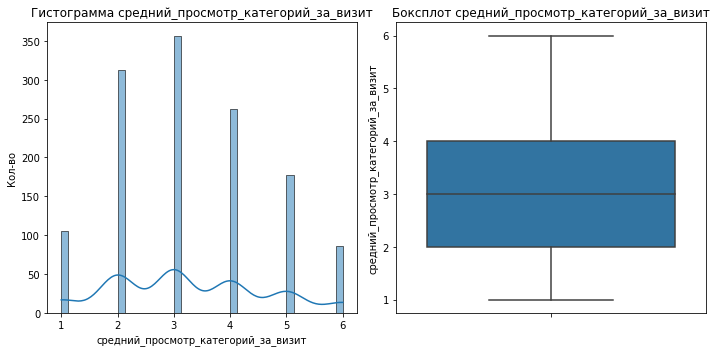

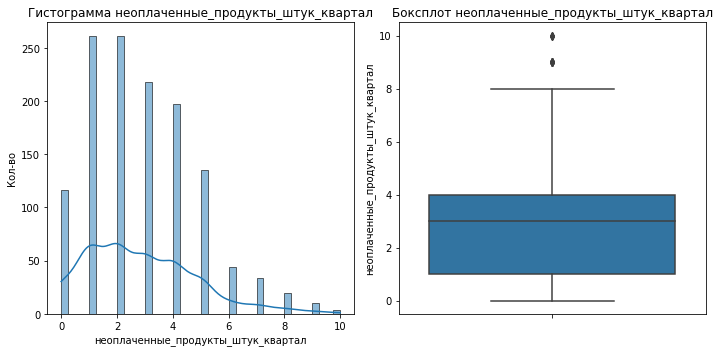

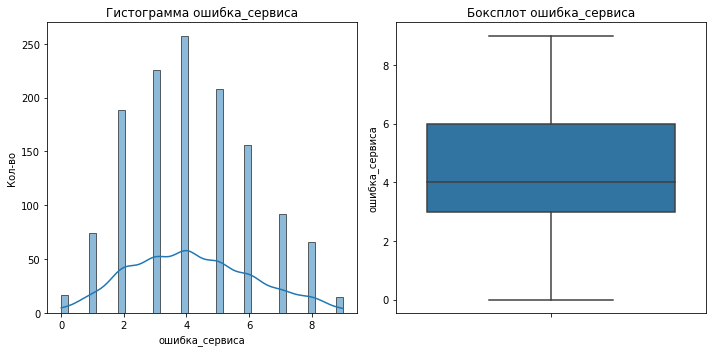

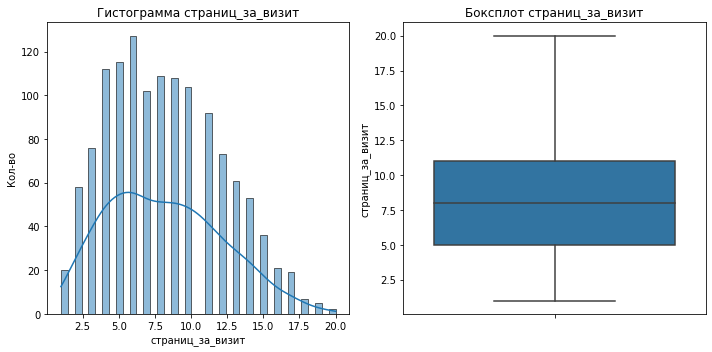

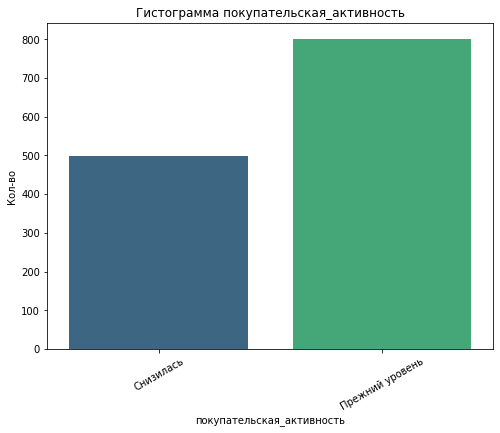

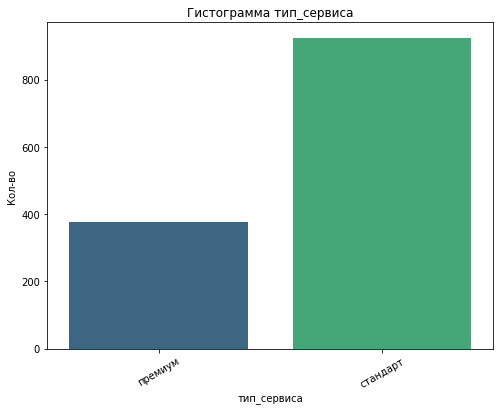

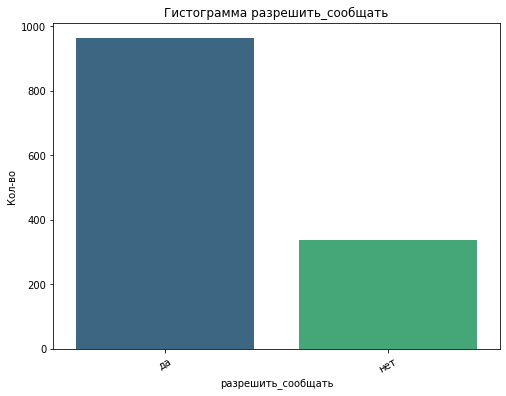

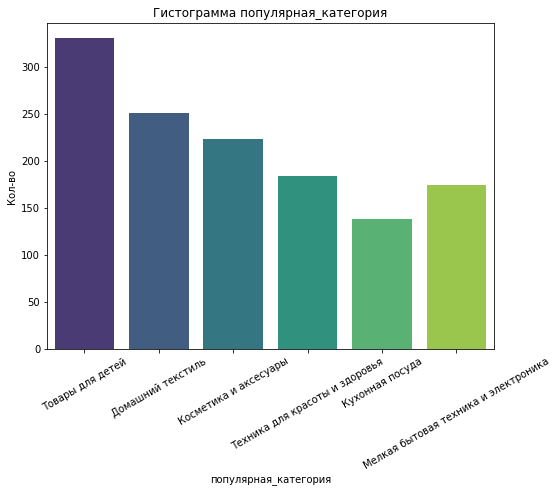

In [28]:
# Разделение данных на числовые и категориальные признаки
numeric_features = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
                    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']

categorical_features = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

# Построение гистограмм и боксплотов для числовых признаков
for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=market_file, x=feature, bins=40, kde=True)
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Кол-во')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=market_file, y=feature)
    plt.title(f'Боксплот {feature}')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

# Построение гистограмм для категориальных признаков
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=market_file, x=feature, palette='viridis')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Кол-во')
    plt.xticks(rotation=30)
    plt.show()

Устраним выбросы

Выбросы устранены, идём дальше

#### market_money

In [29]:
print(market_money.describe())

                  id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000


Сравнение среднего и медианы указывает на возможное наличие выбросов в данных

Построим гистограмму и ящик с усами для дальнейшего анализа выбросов

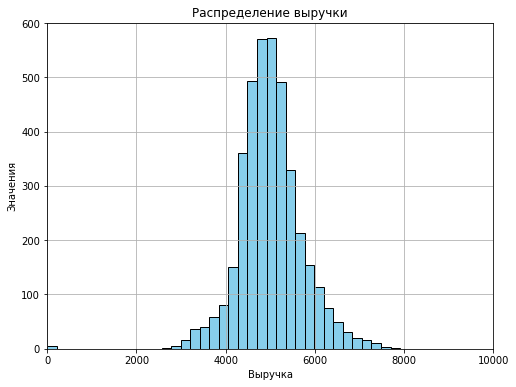

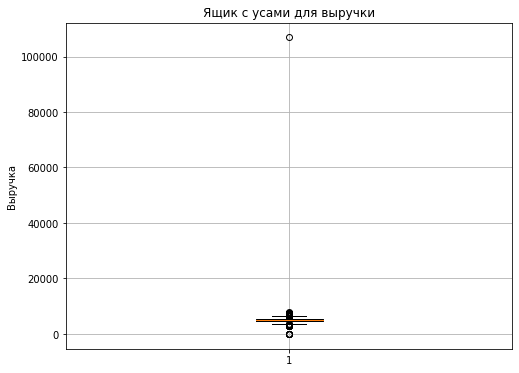

In [30]:
# Гистограмма распределения выручки
plt.figure(figsize=(8, 6))
plt.hist(market_money['выручка'], bins=500, color='skyblue', edgecolor='black')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Значения')
plt.xlim(left=0, right=10000)
plt.grid(True)
plt.show()

# Ящик с усами для выручки
plt.figure(figsize=(8, 6))
plt.boxplot(market_money['выручка'])
plt.title('Ящик с усами для выручки')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

Устраним выброс

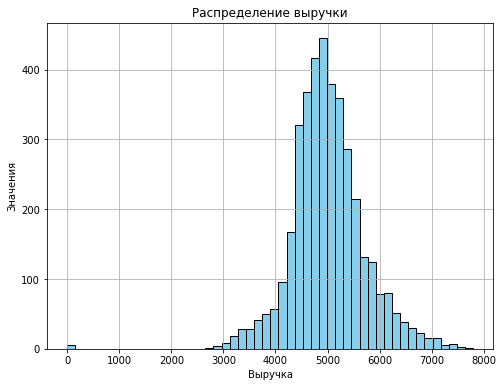

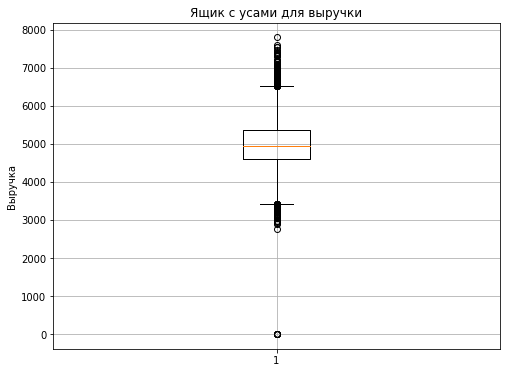

In [31]:
# Удаление выбросов
market_money.drop(market_money[market_money['выручка'] > 10000].index, inplace=True)

# Гистограмма распределения выручки после удаления выбросов
plt.figure(figsize=(8, 6))
plt.hist(market_money['выручка'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Значения')
plt.grid(True)
plt.show()

# Ящик с усами после удаления выбросов
plt.figure(figsize=(8, 6))
plt.boxplot(market_money['выручка'])
plt.title('Ящик с усами для выручки')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

Выброс устранен, идём дальше

#### market_time

In [32]:
print(market_time.describe())

                  id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000


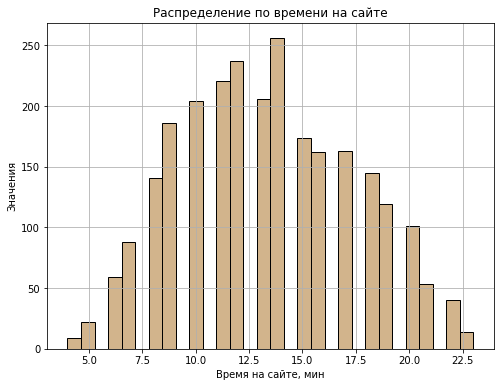

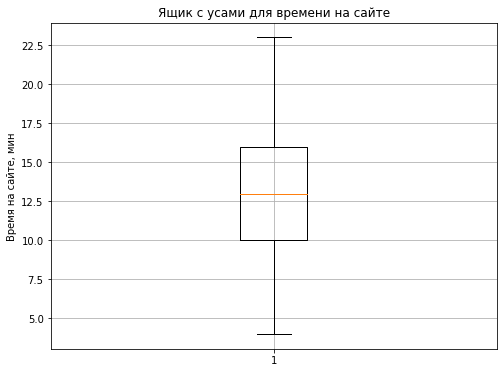

In [33]:
# Гистограмма распределения времени на сайте
plt.figure(figsize=(8, 6))
plt.hist(market_time['минут'], bins=30, color='tan', edgecolor='black')
plt.title('Распределение по времени на сайте')
plt.xlabel('Время на сайте, мин')
plt.ylabel('Значения')
plt.grid(True)
plt.show()

# Ящик с усами для времени на сайте
plt.figure(figsize=(8, 6))
plt.boxplot(market_time['минут'])
plt.title('Ящик с усами для времени на сайте')
plt.ylabel('Время на сайте, мин')
plt.grid(True)
plt.show()

Выбросов нет, идём дальше

#### money

In [34]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


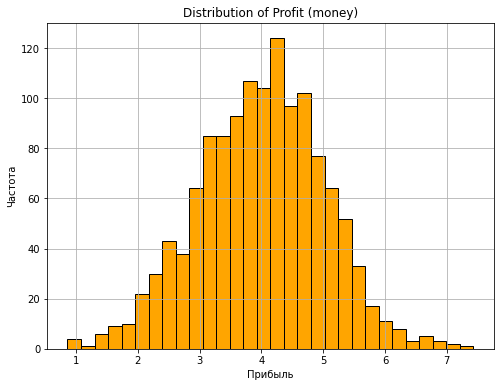

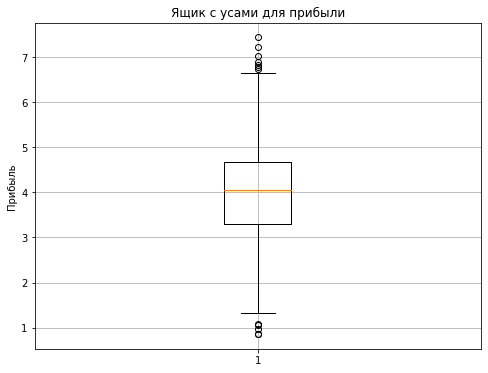

In [35]:
# Гистограмма распределения прибыли
plt.figure(figsize=(8, 6))
plt.hist(money['прибыль'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Profit (money)')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Ящик с усами для прибыли
plt.figure(figsize=(8, 6))
plt.boxplot(money['прибыль'])
plt.title('Ящик с усами для прибыли')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

Не думаю, что стоит считать выбросами просто разные суммы покупок разных покупателей и их убирать, тем более, что эти данные нам далее не понадобятся

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Весь этап с графическим анализом признаков выполнен верно!👍
</div>

### Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [36]:
pivoted_market_money = market_money.pivot(index='id', columns='период_доход', values='выручка')

# Сбрасываем многоуровневые индексы, чтобы получить плоскую таблицу
pivoted_market_money.reset_index(inplace=True)

# Выводим первые несколько строк для проверки результата
pivoted_market_money

период_доход,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7
1296,216644,4729.0,5299.0,5353.0
1297,216645,5160.0,5334.0,5139.2
1298,216646,4923.0,4725.0,5224.6


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично! Таблица <code>market_money</code> переведена из «длинной» в «широкую». В каждой строке у нас информация об уникальном клиенте. Обрати внимание на число строк — оно должно совпадать с количеством строк в <code>market_file</code>, где каждая строка — уникальный клиент.
</div>

Оставим только тех клиентов, которые совершали покупки в КАЖДЫЙ из 3 месяцев

In [37]:
# Удаляем строки с нулевыми значениями и NaN
pivoted_market_money = pivoted_market_money.dropna(subset=['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'])
pivoted_market_money = pivoted_market_money[(pivoted_market_money[['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']] != 0).all(axis=1)]

# Выводим первые несколько строк для проверки результата
pivoted_market_money

период_доход,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7
1296,216644,4729.0,5299.0,5353.0
1297,216645,5160.0,5334.0,5139.2
1298,216646,4923.0,4725.0,5224.6


Переименуем столбцы, чтобы впоследствии избежать конфликтов

In [38]:
pivoted_market_money = pivoted_market_money.rename(columns={
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
    'текущий_месяц': 'выручка_текущий_месяц'
})

### Переведём market_time из "длинной" в "широкую"

In [39]:
pivoted_market_time = market_time.pivot(index='id', columns='период_сайт', values='минут')

# Сбрасываем многоуровневые индексы, чтобы получить плоскую таблицу
pivoted_market_time.reset_index(inplace=True)

# Выводим первые несколько строк для проверки результата
pivoted_market_time

период_сайт,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


Переименуем столбцы, чтобы впоследствии избежать конфликтов

In [40]:
pivoted_market_time = pivoted_market_time.rename(columns={
    'предыдущий_месяц': 'минут_предыдущий_месяц',
    'текущий_месяц': 'минут_текущий_месяц'
})

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> market_time подготовлена к объединению 👌
</div>

## Объединение таблиц

4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv.
- Данные о прибыли из файла money.csv при моделировании вам не понадобятся.

4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов.
- В итоговой таблице сделайте отдельный столбец для каждого периода.

### Объединяем таблицы по id

In [41]:
merged_data = market_file.merge(pivoted_market_money, on='id').merge(pivoted_market_time, on='id')

### В итоговой таблице получаем отдельный столбец для каждого периода:

In [42]:
merged_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


### Сделаем индексы из столбца id

In [43]:
merged_data.set_index('id', inplace=True)

In [44]:
merged_data.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648
std,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000
50%,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000
75%,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


In [45]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

#### Объединили таблицы, получив информацию ТОЛЬКО о клиентах с интересующей нас(3мес) покупательной активностью

## Корреляционный анализ
Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

### Матрица корреляций

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
Матрица Корреляции Phik:


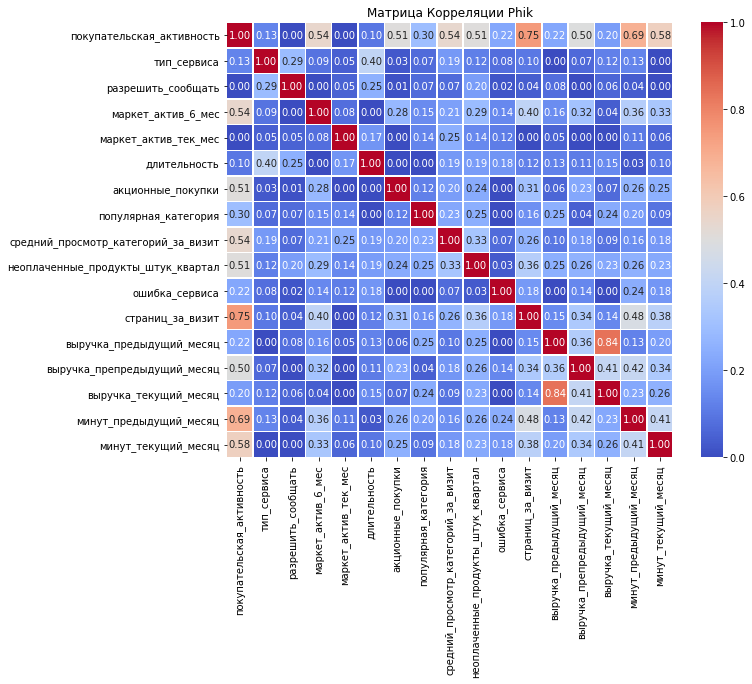

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
покупательская_активность,1.000000,NaN,NaN,0.544831,NaN,NaN,0.506276,NaN,0.539607,0.505655,NaN,0.749888,NaN,NaN,NaN,0.685138,0.57677
тип_сервиса,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
разрешить_сообщать,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
маркет_актив_6_мес,0.544831,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
маркет_актив_тек_мес,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
длительность,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
акционные_покупки,0.506276,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
популярная_категория,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
средний_просмотр_категорий_за_визит,0.539607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
неоплаченные_продукты_штук_квартал,0.505655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
import phik

correlation_matrix_phik = merged_data.phik_matrix()

# Выводим матрицу корреляций
print("Матрица Корреляции Phik:")
#print(correlation_matrix_phik)

# Визуализируем матрицу корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_phik, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица Корреляции Phik')
plt.show()

# Устанавливаем значение корреляции, выше которого мы хотим выводить
threshold = 0.50

# Фильтруем матрицу корреляций
high_correlations = correlation_matrix_phik[correlation_matrix_phik.abs() > threshold]

# Отображаем только значения корреляций выше порога
high_correlations

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


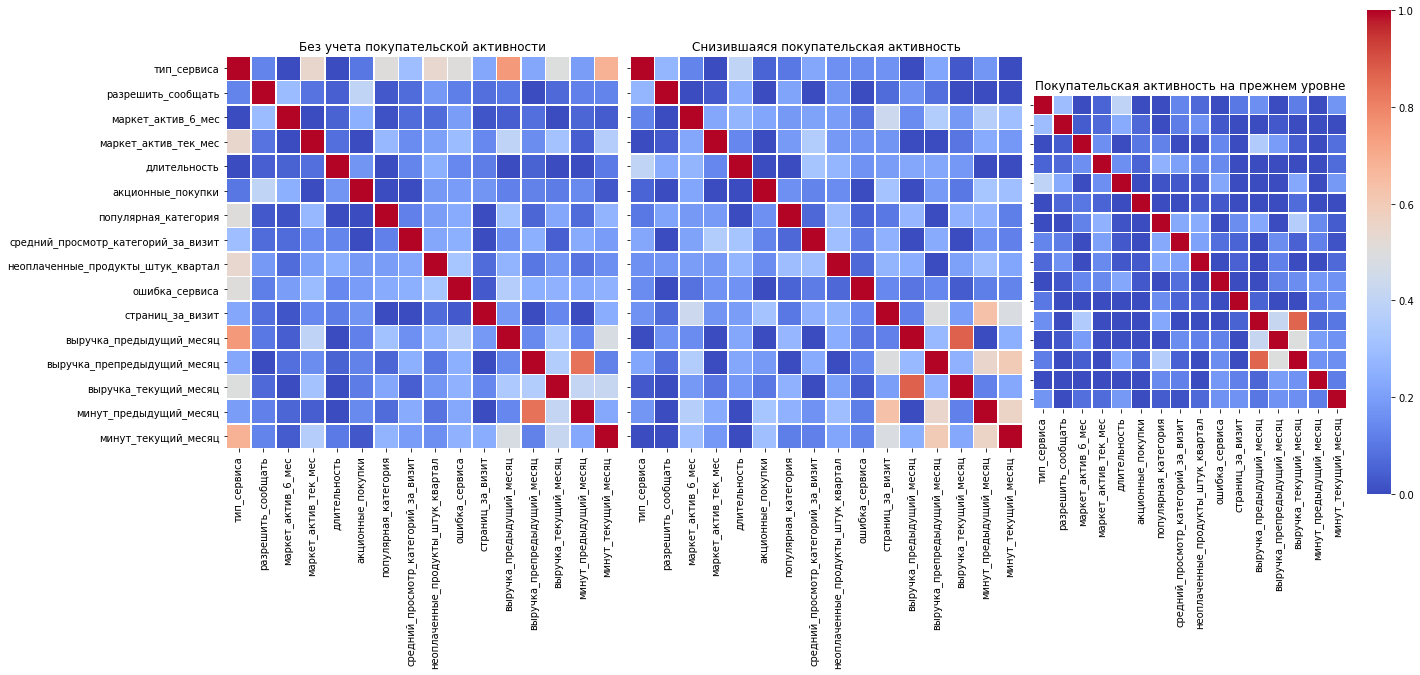

In [47]:
correlation_matrix_phik_lower = merged_data[merged_data['покупательская_активность'] == 'Снизилась'].phik_matrix()
correlation_matrix_phik_const = merged_data[merged_data['покупательская_активность'] == 'Прежний уровень'].phik_matrix()

# Визуализируем матрицу корреляций
fig, ax = plt.subplots(1, 3, figsize=(20, 9), sharex=True, sharey=True)
sns.heatmap(correlation_matrix_phik, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax[0], cbar=False)
sns.heatmap(correlation_matrix_phik_lower, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax[1], cbar=False)
sns.heatmap(correlation_matrix_phik_const, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax[2], cbar=True)
ax[0].set_title('Без учета покупательской активности')
ax[1].set_title('Снизившаяся покупательская активность')
ax[2].set_title('Покупательская активность на прежнем уровне')
for a in ax:
    a.set_aspect('equal')


fig.tight_layout()
#plt.title('Матрица Корреляции Phik для покупателей со снизившейся активностью')
plt.show()


### Мультиколлинеарность:

1. Покупательская активность:
- Сильно коррелирует с акционные_покупки (приблизительно 0.60), что свидетельствует о том, что акции стимулируют покупательскую активность
- Сильно коррелирует с средний_просмотр_категорий_за_визит (примерно 0.53) и количеством страниц_за_визит (приблизительно 0.68), что указывает на влияние активности на сайте на поведение покупателей
- Коррелирует с минут_предыдущий_месяц (примерно 0.65), что может указывать на то, что большее время, проведенное на сайте, связано с увеличением покупательской активности

2. Выручка:
- выручка_текущий_месяц и выручка_предыдущий_месяц сильно коррелируют с страниц_за_визит (приблизительно 0.76) и минут_предыдущий_месяц (примерно 0.65), что указывает на влияние этих факторов
- выручка_предыдущий_месяц также имеет заметную корреляцию с выручкой текущего месяца (примерно 0.76), что может говорить о том, что активные и лояльные клиенты с большей вероятностью будут ежемесячно совершать сопоставимые по цене покупки

3. Ошибка сервиса:
- По какой-то причине меет корреляцию с покупательской активностью (примерно 0.69), что может указывать на влияние ошибок сервиса на снижение активности пользователей

#### Возможно стоит добавить столбцы с разницей выручки, чтобы удалить мультиколлинеарность:

## Использование пайплайнов
Примените все изученные модели. Для этого используйте пайплайны.

6.1 Во время подготовки данных используйте ColumnTransformer.
- Количественные и категориальные признаки обработайте в пайплайне раздельно.
- Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

In [48]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    merged_data.drop('покупательская_активность', axis=1),
    merged_data['покупательская_активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=merged_data['покупательская_активность']
)

ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
               'минут_предыдущий_месяц', 'минут_текущий_месяц', 'неоплаченные_продукты_штук_квартал']

ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['премиум', 'стандарт']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l1'))
])

6.2 Обучите четыре модели:
- KNeighborsClassifier()
- DecisionTreeClassifier()
- LogisticRegression()
- SVC()

Для каждой из них подберите как минимум один гиперпараметр.

Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

In [49]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10, 100, 1000],  
        #'models__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        #'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
- Использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно
- Использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель

In [50]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

pipe_final.fit(X_train, y_train)
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),...
                                  

## Анализ важности признаков
Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP

In [51]:
# Извлекаем модель из пайплайна
model = randomized_search.best_estimator_['models']

# достаем датафрейм в начальном виде
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)

In [52]:
# достаем названия фич
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)


# склеиваем их в одну строку
col_names = np.concatenate([ohe_feature_names, ord_columns, num_columns])
col_names, len(col_names)

(array(['разрешить_сообщать_нет',
        'популярная_категория_Косметика и аксесуары',
        'популярная_категория_Кухонная посуда',
        'популярная_категория_Мелкая бытовая техника и электроника',
        'популярная_категория_Техника для красоты и здоровья',
        'популярная_категория_Товары для детей', 'тип_сервиса',
        'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
        'акционные_покупки', 'средний_просмотр_категорий_за_визит',
        'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц',
        'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
        'минут_предыдущий_месяц', 'минут_текущий_месяц',
        'неоплаченные_продукты_штук_квартал'], dtype=object),
 20)

In [53]:
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=col_names)
# в датафрейме 324 строки (как и было) и 20 колонок, это правильно

In [54]:
# Создаем Explainer
explainer = shap.LinearExplainer(model, X_test_preprocessed)

In [55]:
# Вычисляем значения SHAP
shap_values = explainer(X_test_preprocessed)

### Строим графики важности признаков

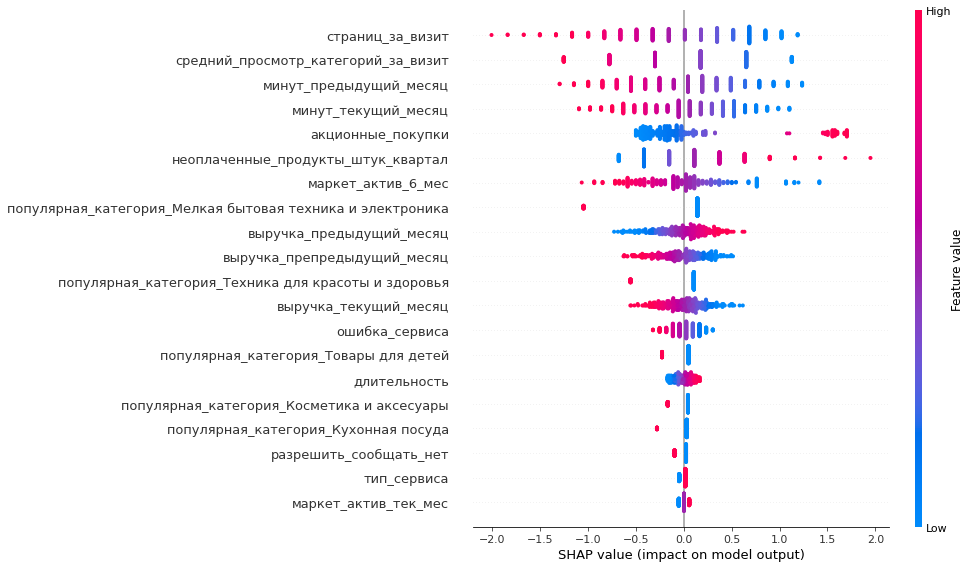

In [56]:
shap.summary_plot(
    shap_values,
    plot_size=(14, 8))

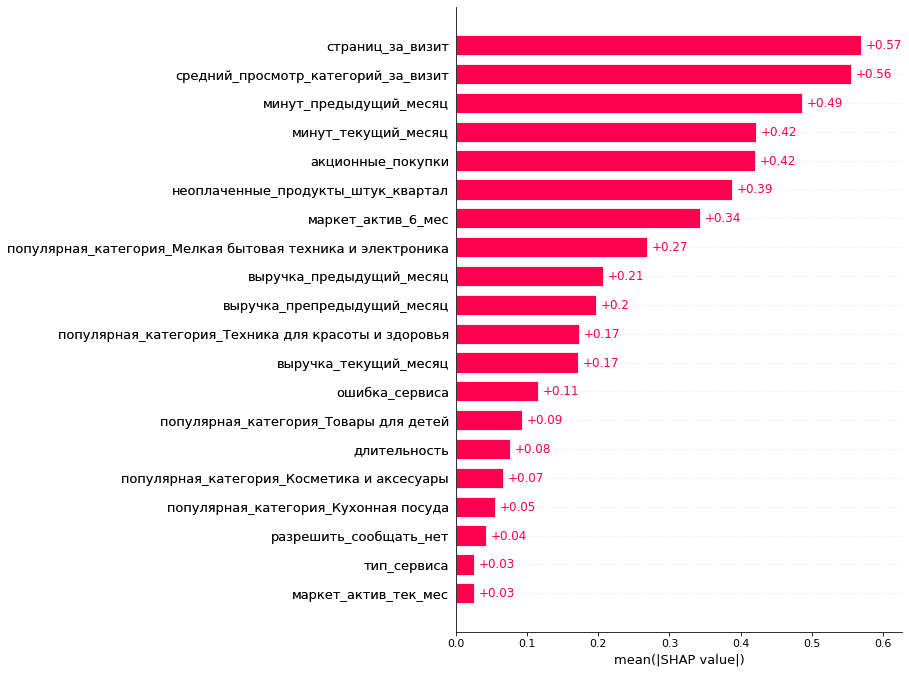

In [57]:
shap.plots.bar(shap_values, max_display=len(X_test_preprocessed.columns))

### Делаем выводы о значимости признаков:
- Какие признаки мало значимы для модели
- Какие признаки сильнее всего влияют на целевой признак
- Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений

Можно сделать вывод о том, что малозначимыми признаками являются:
- популярные категории (кроме техники)
- тип_сервиса
- маркет_актив_тек_мес
- разрешить_сообщать
- длительность
- ошибка_сервиса
- выручка (вся)

Сильнее всего на целевой признак влияют признаки:
- страниц_за_визит - больше страниц = больше шанс найти необходимое и купить
- средний_просмотр_категорий_за визит - более скрупулёзный поиск = больше шанс найти необходимое и купить
- акционные_покупки - чем больше акционных покупок у клиента, тем больше вероятность снижения его покупательской активности
- минут (оба месяца) - больше времени просмотра товаров = больше покупок
- неоплаченные_продукты_штук_квартал - чем больше неоплаченных продуктов добавлено у клиента, тем больше вероятность снижения его покупательской активности
- маркет_актив_6_мес - больше маркетинговых коммуникаций = больше покупок



Оптимизация маркетинговых коммуникаций:
- Учитывая сильное влияние маркетинговых коммуникаций на покупательскую активность, компания может сосредоточиться на улучшении своих маркетинговых стратегий и активно взаимодействовать с клиентами через различные каналы связи

Анализ поведения клиентов на сайте:
- Информация о поведении клиентов на сайте, такая как количество просмотренных страниц и время пребывания на сайте, может быть использована для персонализации контента, предложений и рекомендаций, что поможет улучшить пользовательский опыт и стимулировать покупательскую активность

## Сегментация покупателей

### Выполните сегментацию покупателей.

Используйте результаты моделирования и данные о прибыльности покупателей

Создадим сегмент покупателей с высокой вероятностью снижения покупательской активности и высокой прибыльностью

In [58]:
predicted_probabilities = randomized_search.predict_proba(X_test)[:, 1]

X_test['предсказанная_вероятность_снижения'] = predicted_probabilities

merged_data_with_money = X_test.merge(money, on='id')

high_profit_segment = merged_data_with_money[(merged_data_with_money['предсказанная_вероятность_снижения'] > 0.5) & 
                                             (merged_data_with_money['прибыль'] > merged_data_with_money['прибыль'].mean())]

In [61]:
high_profit_segment

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,предсказанная_вероятность_снижения,прибыль
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.503642,4.40
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.970247,4.18
18,215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4045.0,4963.0,4206.2,11,10,0.953739,4.50
21,215484,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,5059.0,4267.0,5018.7,5,7,0.915586,5.64
38,215496,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,2,4,5020.0,4896.0,5237.1,11,11,0.941283,4.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,215668,премиум,да,4.4,4,343,0.94,Товары для детей,2,9,2,2,5567.5,4723.0,5293.2,6,9,0.997877,4.49
302,215356,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,0.924186,4.93
303,215651,стандарт,нет,2.4,3,715,0.40,Кухонная посуда,3,5,5,5,5109.5,4217.0,5498.2,10,8,0.957446,5.15
321,215716,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,3067.0,4165.0,3343.9,13,14,0.884936,4.07


Получили требуемый сегмент

### Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
- Проведите графическое и аналитическое исследование группы покупателей
- Сделайте предложения по работе с сегментом для увеличения покупательской активности

#### Проведём исследование

##### Начнем с популярных категорий

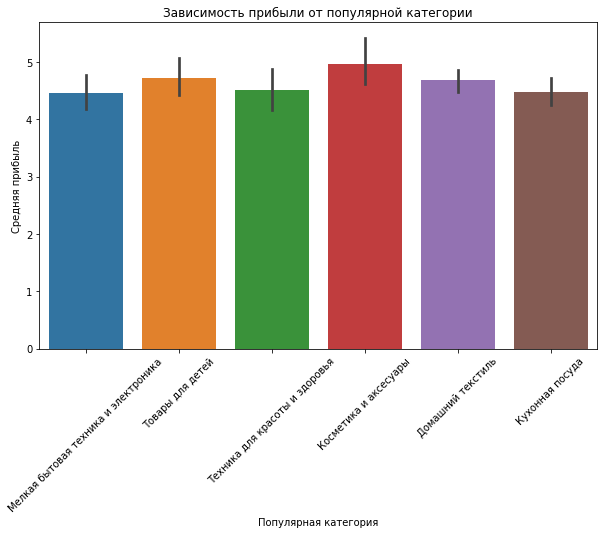

In [105]:
# График зависимости прибыли от популярной категории
plt.figure(figsize=(10, 6))
sns.barplot(x='популярная_категория', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от популярной категории')
plt.xlabel('Популярная категория')
plt.ylabel('Средняя прибыль')
plt.xticks(rotation=45)
plt.show()

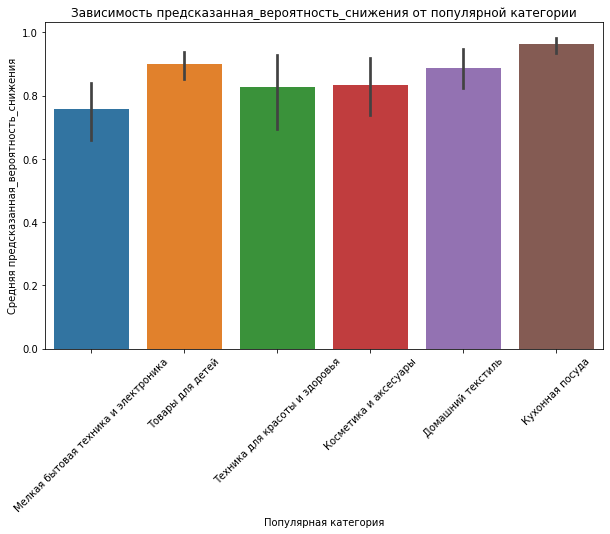

In [115]:
# График зависимости прибыли от популярной категории
plt.figure(figsize=(10, 6))
sns.barplot(x='популярная_категория', y='предсказанная_вероятность_снижения', data=high_profit_segment)
plt.title('Зависимость предсказанная_вероятность_снижения от популярной категории')
plt.xlabel('Популярная категория')
plt.ylabel('Средняя предсказанная_вероятность_снижения')
plt.xticks(rotation=45)
plt.show()

Можно заметить, что среди популярных категорий нет таких, что слишком сильно выделялись бы, хотя самые прибыльные это явно:
1. Косметика и аксесуары
2. Товары для детей
3. Домашний текстиль

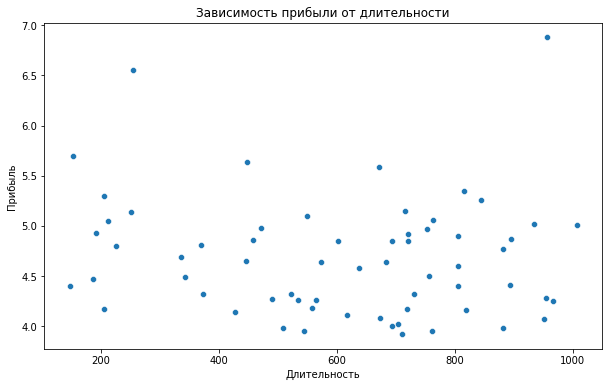

In [106]:
# График зависимости прибыли от длительности
plt.figure(figsize=(10, 6))
sns.scatterplot(x='длительность', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от длительности')
plt.xlabel('Длительность')
plt.ylabel('Прибыль')
plt.show()

Переведём признак в категориальный:

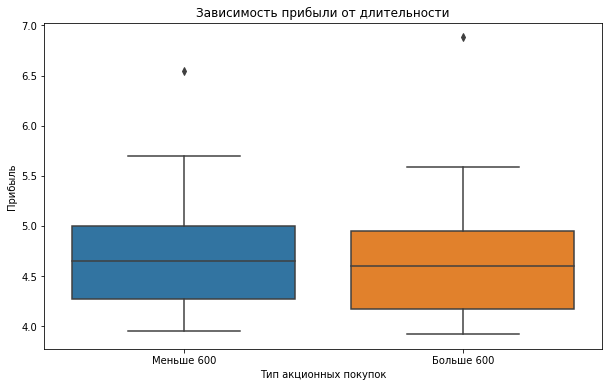

In [107]:
# Добавляем новый категориальный признак "тип_длительности"
high_profit_segment['тип_длительности'] = pd.cut(high_profit_segment['длительность'], bins=[-np.inf, 600, np.inf], labels=['Меньше 600', 'Больше 600'])

# График зависимости прибыли от типа акционных покупок
plt.figure(figsize=(10, 6))
sns.boxplot(x='тип_длительности', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от длительности')
plt.xlabel('Тип акционных покупок')
plt.ylabel('Прибыль')
plt.show()

Можно заметить, что чем "новее" клиент, тем больше прибыли он приносит

##### Посмотрим, важен ли ценным клиентам тип сервиса?

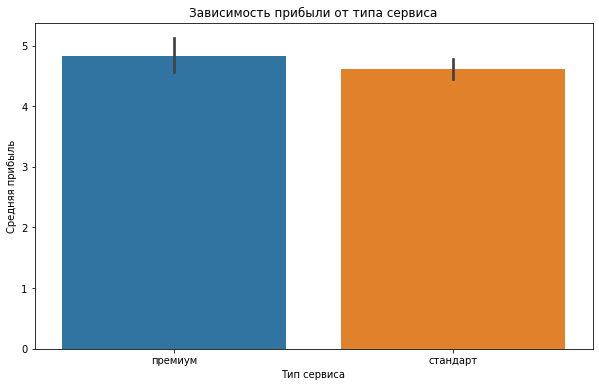

In [108]:
# График зависимости прибыли от типа сервиса
plt.figure(figsize=(10, 6))
sns.barplot(x='тип_сервиса', y='прибыль', data=high_profit_segment, order=['премиум', 'стандарт'])
plt.title('Зависимость прибыли от типа сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Средняя прибыль')
plt.show()

Да, прибыль "премиум-клиентов" выше

##### Посмотрим, возможно ли удержать ценных клиентов акциями?

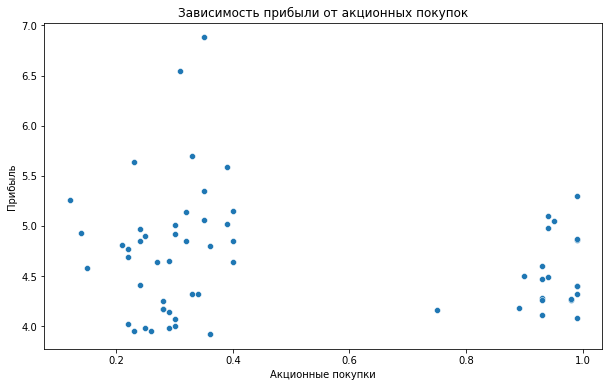

In [109]:
# График зависимости прибыли от акционных покупок
plt.figure(figsize=(10, 6))
sns.scatterplot(x='акционные_покупки', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от акционных покупок')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

Переведём признак в категориальный:

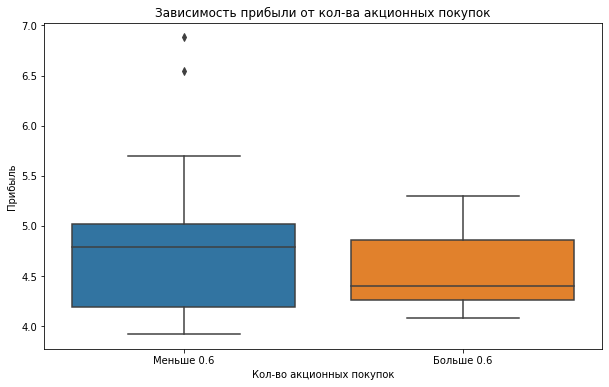

In [119]:
# Добавляем новый категориальный признак "тип_акционных_покупок"
high_profit_segment['колво_акционных_покупок'] = pd.cut(high_profit_segment['акционные_покупки'], bins=[-np.inf, 0.6, np.inf], labels=['Меньше 0.6', 'Больше 0.6'])

# График зависимости прибыли от типа акционных покупок
plt.figure(figsize=(10, 6))
sns.boxplot(x='колво_акционных_покупок', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от кол-ва акционных покупок')
plt.xlabel('Кол-во акционных покупок')
plt.ylabel('Прибыль')
plt.show()

Как можно понять, увеличение количества акционных покупок не влияет на прибыль

##### Посмотрим на влияние числа просмотренных страниц и категорий:

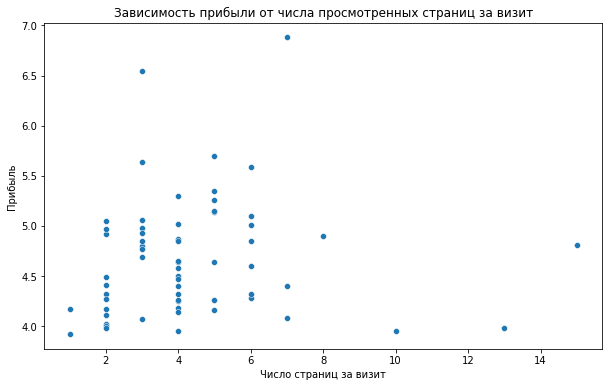

In [111]:
# График зависимости прибыли от числа просмотренных страниц за визит
plt.figure(figsize=(10, 6))
sns.scatterplot(x='страниц_за_визит', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от числа просмотренных страниц за визит')
plt.xlabel('Число страниц за визит')
plt.ylabel('Прибыль')
plt.show()

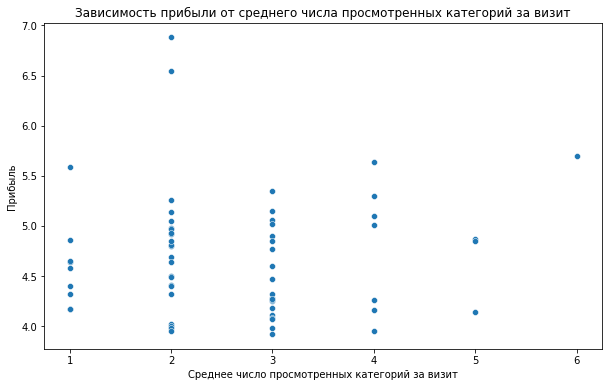

In [86]:
# График зависимости прибыли от среднего числа просмотренных категорий за визит
plt.figure(figsize=(10, 6))
sns.scatterplot(x='средний_просмотр_категорий_за_визит', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от среднего числа просмотренных категорий за визит')
plt.xlabel('Среднее число просмотренных категорий за визит')
plt.ylabel('Прибыль')
plt.show()

Нет смысла работать улучшать системы рекомендаций, так как прибыль не сильно растет от количества разных товаров, просмотренных клиентом

##### Посмотрим на зависимость от количества маркетинговых коммуникаций:

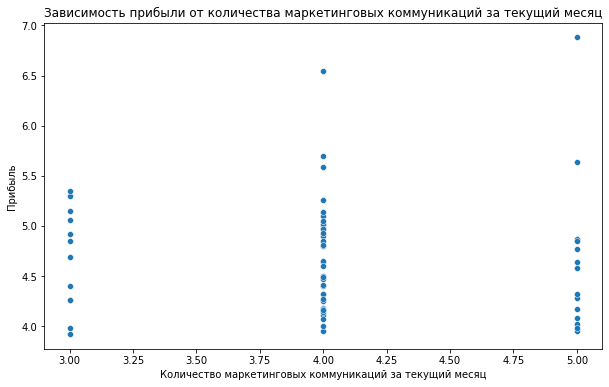

In [112]:
# График зависимости прибыли от количества маркетинговых коммуникаций (за последний месяц, ведь нас
# не интересует зависимость в долгосрочной перспективе, если мы хотим предсказать лишь следующий месяц)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='маркет_актив_тек_мес', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от количества маркетинговых коммуникаций за текущий месяц')
plt.xlabel('Количество маркетинговых коммуникаций за текущий месяц')
plt.ylabel('Прибыль')
plt.show()

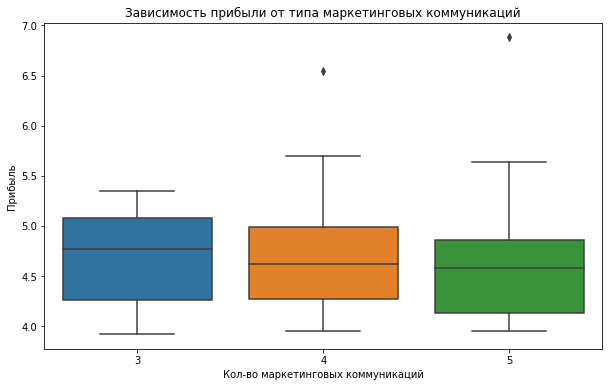

In [113]:
# Создание категориального признака "колво_маркетинговых_коммуникаций"
high_profit_segment['колво_маркетинговых_коммуникаций'] = pd.cut(high_profit_segment['маркет_актив_тек_мес'], bins=[2.9, 3.9, 4.9, 5.1], labels=['3', '4', '5'])

# График зависимости прибыли от кол-ва маркетинговых коммуникаций
plt.figure(figsize=(10, 6))
sns.boxplot(x='колво_маркетинговых_коммуникаций', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от типа маркетинговых коммуникаций')
plt.xlabel('Кол-во маркетинговых коммуникаций')
plt.ylabel('Прибыль')
plt.show()


Можно с уверенностью сказать, что увеличение количества маркетинговых коммуникаций положительно влияет на прибыль, но это не значит, что нужно просто увеличивать их количество, потому что закономерность тут больше похожа на Первый закон Госсена:


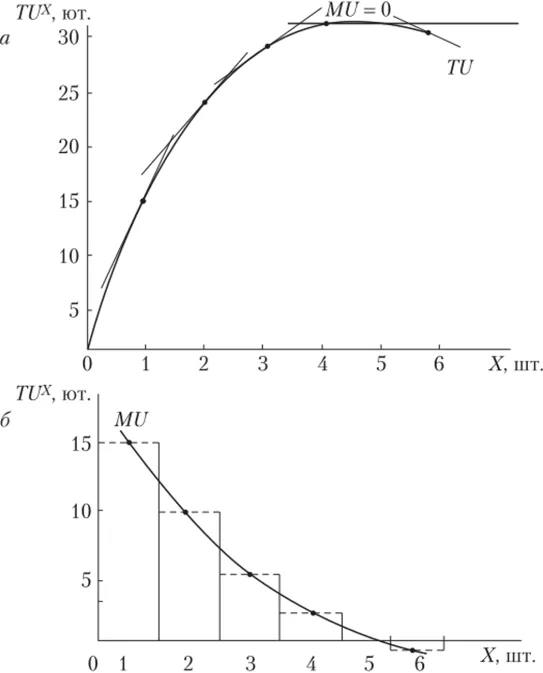

##### Посмотрим на зависимость от количества ошибок сервиса:

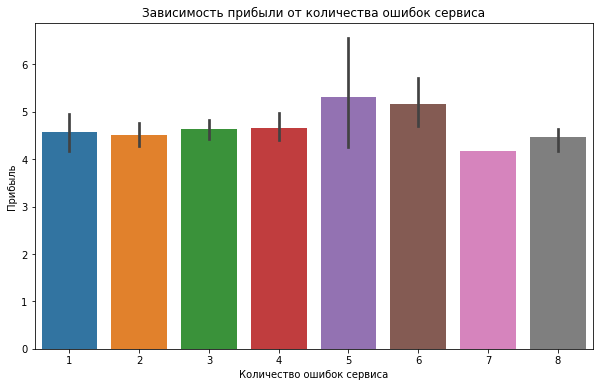

In [114]:
# График зависимости прибыли от количества ошибок сервиса
plt.figure(figsize=(10, 6))
sns.barplot(x='ошибка_сервиса', y='прибыль', data=high_profit_segment)
plt.title('Зависимость прибыли от количества ошибок сервиса')
plt.xlabel('Количество ошибок сервиса')
plt.ylabel('Прибыль')
plt.show()

Ошибки сервиса не особо влияют на прибыль, пока их не становится слишком много (7+), так что в идеале было бы хорошо их исправить

### Сделайте выводы о сегментах:
- Какой сегмент вы взяли для дополнительного исследования,
- Какие предложения вы сделали и почему.

#### Я взял сегмент клиентов с высокой прибыльностью и высокой вероятностью понижения покупательской активности

#### Предложения:

- Замотивировать клиентов приобретать "премиум" путём скидки на него или добавления новых преимуществ, так как это увеличивает прибыль
- Улучшить качественный аспект системы рекомендаций и персонализации предложения товаров на сайте, чтобы клиентам не нужно было просматривать и перебирать множество вариантов (вспомним, как во время первичного анализа данных мы пришли к выводу, что уже имеющиеся лояльные клиенты склонны совершать крупные покупки снова, так что почему бы им не помочь), так как не имеет смысла улучшать количество рекомендуемых товаров (см. 8.2.0.4)
- Сократить расходы на маркетинговые коммуникации, снизив их количество до максимально эффективного (после 4 уже нет такого прироста)
- Исправить ошибки сервиса
- Сократить количество акций или сделать их частью преимуществ "премиума", так как они не помогают увеличить прибыльность и активность

 ## Общий вывод

Шаг 1. Загрузка данных:
- Данные загружены из файлов market_file.csv, market_money.csv, market_time.csv и money.csv
- Проверено соответствие данных описанию

Шаг 2. Предобработка данных:
- Выполнена необходимая предобработка данных

Шаг 3. Исследовательский анализ данных:
- Проведен исследовательский анализ данных из каждой таблицы
- Таблицы переведены из "длинных" в "широкие"
- Отобраны клиенты с покупательской активностью не менее 3 месяцев

Шаг 4. Объединение таблиц:
- Объединены таблицы
- Созданы отдельные столбцы для каждого периода данных о выручке и времени на сайте
- Осталась информация ТОЛЬКО о клиентах с активностью не менее 3 месяцев

Шаг 5. Корреляционный анализ:
- Проведен корреляционный анализ признаков методом phik в итоговой таблице для моделирования
- Сделаны выводы

Шаг 6. Использование пайплайнов:
- Применены различные модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()
- Подобраны гиперпараметры моделей
- Выбрана лучшая модель

Шаг 7. Анализ важности признаков:
- Оценена важность признаков для лучшей модели с использованием метода SHAP
- Сделаны выводы о значимости признаков и предложения для моделирования и принятия бизнес-решений

Шаг 8. Сегментация покупателей:
- Выполнена сегментация покупателей на основе результатов моделирования и данных о прибыльности
- Выбрана группа покупателей "с высокой вероятностью снижения покупательской активности и высокой прибыльностью" для дополнительного исследования и предложены меры по увеличению их покупательской активности